In [1]:
%reset

import keras
from keras import models
from keras.models import Sequential, Model
from keras import layers
from keras.layers import Reshape, Activation, Conv2D, Input, MaxPooling2D, BatchNormalization, Flatten, Dense
from keras.layers.advanced_activations import LeakyReLU
from keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard
from keras.optimizers import SGD, Adam
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import random
import os

%matplotlib inline


Once deleted, variables cannot be recovered. Proceed (y/[n])? y


Using TensorFlow backend.


In [2]:
exec(open("tiny-yolo/utils.py").read())

NORM_H, NORM_W = 416, 416
GRID_H, GRID_W = 13 , 13
BATCH_SIZE = 64
BOX = 5
ORIG_CLASS = 20


LABELS = ['aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 
          'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']

ANCHORS = '1.08,1.19,  3.42,4.41,  6.63,11.38,  9.42,5.11,  16.62,10.52'
ANCHORS = [float(ANCHORS.strip()) for ANCHORS in ANCHORS.split(',')]

SCALE_NOOB, SCALE_CONF, SCALE_COOR, SCALE_PROB = 0.5, 5.0, 5.0, 1.0

In [3]:
model = Sequential()

# Layer 1
model.add(Conv2D(16, (3,3), strides=(1,1), padding='same', use_bias=False, input_shape=(416,416,3)))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 2 - 5
for i in range(0,4):
    model.add(Conv2D(32*(2**i), (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))
    model.add(MaxPooling2D(pool_size=(2, 2)))

# Layer 6
model.add(Conv2D(512, (3,3), strides=(1,1), padding='same', use_bias=False))
model.add(BatchNormalization())
model.add(LeakyReLU(alpha=0.1))
model.add(MaxPooling2D(pool_size=(2, 2), strides=(1,1), padding='same'))

# Layer 7 - 8
for _ in range(0,2):
    model.add(Conv2D(1024, (3,3), strides=(1,1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.1))

# Layer 9
model.add(Conv2D(BOX * (4 + 1 + ORIG_CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal'))
model.add(Activation('linear'))
model.add(Reshape((GRID_H, GRID_W, BOX, 4 + 1 + ORIG_CLASS)))

In [4]:
model.load_weights('tiny-yolo.h5')
#model.load_weights('face-weights.hdf5')

In [5]:
ann_dir = 'FDDB_2010/Annotations/'
img_dir = 'FDDB_2010/JPEGImages/'
anns, labels = parse_annotation(ann_dir, LABELS)

Number of classes present in this ImageNet set: 1


In [6]:
CLASS = 1

In [7]:
import random
for i in range(0,5):
    idx = random.randint(0, 2767)
    print(idx)
    print(anns[idx])

2487
{'object': [{'xmin': 22, 'name': 'face', 'ymax': 76, 'xmax': 41, 'ymin': 50}, {'xmin': 55, 'name': 'face', 'ymax': 107, 'xmax': 113, 'ymin': 27}, {'xmin': 157, 'name': 'face', 'ymax': 106, 'xmax': 197, 'ymin': 44}, {'xmin': 224, 'name': 'face', 'ymax': 126, 'xmax': 267, 'ymin': 58}, {'xmin': 314, 'name': 'face', 'ymax': 141, 'xmax': 376, 'ymin': 64}], 'width': 410, 'height': 280, 'filename': '002487'}
894
{'object': [{'xmin': 84, 'name': 'face', 'ymax': 253, 'xmax': 236, 'ymin': 15}], 'width': 327, 'height': 410, 'filename': '000894'}
1458
{'object': [{'xmin': 124, 'name': 'face', 'ymax': 156, 'xmax': 211, 'ymin': 33}], 'width': 308, 'height': 450, 'filename': '001458'}
2461
{'object': [{'xmin': 75, 'name': 'face', 'ymax': 131, 'xmax': 144, 'ymin': 28}], 'width': 231, 'height': 450, 'filename': '002461'}
666
{'object': [{'xmin': 126, 'name': 'face', 'ymax': 126, 'xmax': 193, 'ymin': 22}], 'width': 308, 'height': 450, 'filename': '000666'}


In [8]:
#ANCHORS = [0.57273, 0.677385, 1.87446, 2.06253, 3.33843, 5.47434, 7.88282, 3.52778, 9.77052, 9.16828]
def custom_loss(y_true, y_pred):
    ### Adjust prediction
    # adjust x and y      
    pred_box_xy = tf.sigmoid(y_pred[:,:,:,:,:2])
    
    # adjust w and h
    pred_box_wh = tf.exp(y_pred[:,:,:,:,2:4]) * np.reshape(ANCHORS, [1,1,1,BOX,2])
    pred_box_wh = tf.sqrt(pred_box_wh / np.reshape([float(GRID_W), float(GRID_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_box_conf = tf.expand_dims(tf.sigmoid(y_pred[:, :, :, :, 4]), -1)
    
    # adjust probability
    pred_box_prob = tf.nn.softmax(y_pred[:, :, :, :, 5:])
    
    y_pred = tf.concat([pred_box_xy, pred_box_wh, pred_box_conf, pred_box_prob], 4)
    print("Y_pred shape: {}".format(y_pred.shape))
    
    ### Adjust ground truth
    # adjust x and y
    center_xy = .5*(y_true[:,:,:,:,0:2] + y_true[:,:,:,:,2:4])
    center_xy = center_xy / np.reshape([(float(NORM_W)/GRID_W), (float(NORM_H)/GRID_H)], [1,1,1,1,2])
    true_box_xy = center_xy - tf.floor(center_xy)
    
    # adjust w and h
    true_box_wh = (y_true[:,:,:,:,2:4] - y_true[:,:,:,:,0:2])
    true_box_wh = tf.sqrt(true_box_wh / np.reshape([float(NORM_W), float(NORM_H)], [1,1,1,1,2]))
    
    # adjust confidence
    pred_tem_wh = tf.pow(pred_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    pred_box_area = pred_tem_wh[:,:,:,:,0] * pred_tem_wh[:,:,:,:,1]
    pred_box_ul = pred_box_xy - 0.5 * pred_tem_wh
    pred_box_bd = pred_box_xy + 0.5 * pred_tem_wh
    
    true_tem_wh = tf.pow(true_box_wh, 2) * np.reshape([GRID_W, GRID_H], [1,1,1,1,2])
    true_box_area = true_tem_wh[:,:,:,:,0] * true_tem_wh[:,:,:,:,1]
    true_box_ul = true_box_xy - 0.5 * true_tem_wh
    true_box_bd = true_box_xy + 0.5 * true_tem_wh
    
    intersect_ul = tf.maximum(pred_box_ul, true_box_ul) 
    intersect_br = tf.minimum(pred_box_bd, true_box_bd)
    intersect_wh = intersect_br - intersect_ul
    intersect_wh = tf.maximum(intersect_wh, 0.0)
    intersect_area = intersect_wh[:,:,:,:,0] * intersect_wh[:,:,:,:,1]
    
    iou = tf.truediv(intersect_area, true_box_area + pred_box_area - intersect_area)
    best_box = tf.equal(iou, tf.reduce_max(iou, [3], True)) 
    best_box = tf.to_float(best_box)
    true_box_conf = tf.expand_dims(best_box * y_true[:,:,:,:,4], -1)
    
    # adjust confidence
    true_box_prob = y_true[:,:,:,:,5:]
    
    y_true = tf.concat([true_box_xy, true_box_wh, true_box_conf, true_box_prob], 4)
    print("Y_true shape: {}".format(y_true.shape))
    #y_true = tf.Print(y_true, [true_box_wh], message='DEBUG', summarize=30000)    
    
    ### Compute the weights
    weight_coor = tf.concat(4 * [true_box_conf], 4)
    weight_coor = SCALE_COOR * weight_coor
    
    weight_conf = SCALE_NOOB * (1. - true_box_conf) + SCALE_CONF * true_box_conf
    
    weight_prob = tf.concat(CLASS * [true_box_conf], 4) 
    weight_prob = SCALE_PROB * weight_prob 
    
    weight = tf.concat([weight_coor, weight_conf, weight_prob], 4)
    print("Weight shape: {}".format(weight.shape))
    
    ### Finalize the loss
    loss = tf.pow(y_pred - y_true, 2)
    loss = loss * weight
    loss = tf.reshape(loss, [-1, GRID_W*GRID_H*BOX*(4 + 1 + CLASS)])
    loss = tf.reduce_sum(loss, 1)
    loss = .5 * tf.reduce_mean(loss)
    
    return loss

In [9]:
# freeze first 8 layers
for layer in model.layers:
    layer.trainable = False

In [10]:
connecting_layer = model.layers[-4].output
top_model = Conv2D(BOX * (4 + 1 + CLASS), (1, 1), strides=(1, 1), kernel_initializer='he_normal') (connecting_layer)
top_model = Activation('linear') (top_model)
top_model = Reshape((GRID_H, GRID_W, BOX, 4 + 1 + CLASS)) (top_model)

In [11]:
new_model = Model(model.input, top_model)

In [12]:
new_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1_input (InputLayer)  (None, 416, 416, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 416, 416, 16)      432       
_________________________________________________________________
batch_normalization_1 (Batch (None, 416, 416, 16)      64        
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 416, 416, 16)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 208, 208, 16)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 208, 208, 32)      4608      
_________________________________________________________________
batch_normalization_2 (Batch (None, 208, 208, 32)      128       
__________

In [13]:
early_stop = EarlyStopping(monitor='loss', 
                           min_delta=0.001, 
                           patience=3, 
                           mode='min', verbose=1)

checkpoint = ModelCheckpoint('face-weights.hdf5', 
                             monitor='loss', 
                             verbose=1, 
                             save_best_only=True, 
                             mode='min', period=1)

In [14]:
optimizer = SGD(lr=0.5e-4, decay=0.0005, momentum=0.9)
#optimizer = Adam(lr=0.5e-4, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
new_model.compile(loss=custom_loss, optimizer=optimizer)


Y_pred shape: (?, 13, 13, 5, 6)
Y_true shape: (?, 13, 13, 5, ?)
Weight shape: (?, 13, 13, 5, 6)


In [ ]:
exec(open("tiny-yolo/utils.py").read())

history = new_model.fit_generator(data_gen(anns, BATCH_SIZE), 
                        int(len(anns)/BATCH_SIZE), 
                        epochs = 200, 
                        verbose = 1,
                        #callbacks = [checkpoint, early_stop])
                        callbacks = [checkpoint])

In [17]:
new_model.load_weights('face-weights.hdf5')

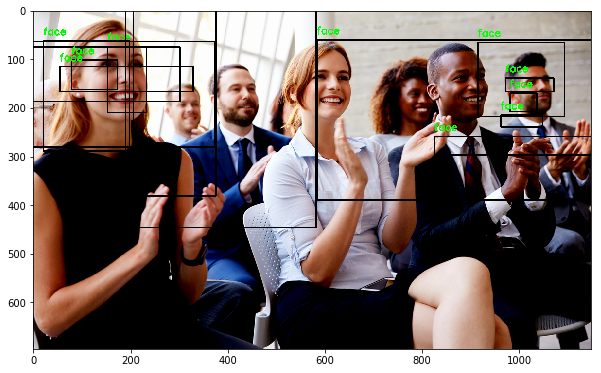

In [18]:
image = cv2.imread('test01.jpg')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = new_model.predict(input_image)

#print netout
THRESHOLD = 0.2
image = interpret_netout(image, netout[0])
plt.imshow(image[:,:,::-1]); plt.show()

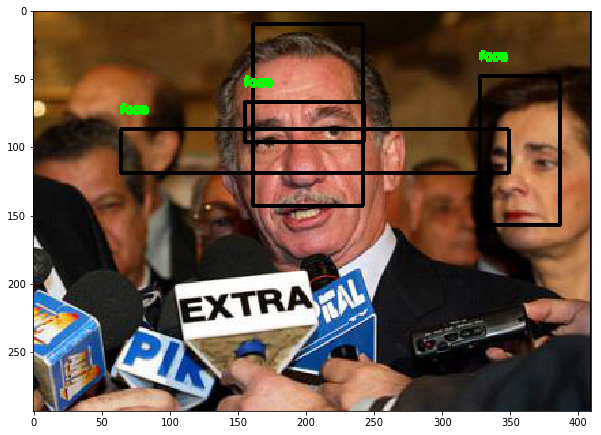

In [19]:
image = cv2.imread('test02.jpg')

plt.figure(figsize=(10,10))

input_image = cv2.resize(image, (416, 416))
input_image = input_image / 255.
input_image = input_image[:,:,::-1]
input_image = np.expand_dims(input_image, 0)

netout = new_model.predict(input_image)

#print netout
THRESHOLD = 0.65
image = interpret_netout(image, netout[0])
plt.imshow(image[:,:,::-1]); plt.show()